# 베스트모델 찾은 후 조기 종료 - 와인 이진분류

In [26]:
import numpy as np 
import pandas as pd
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [27]:
from google.colab import files
up = files.upload()
filename = list(up.keys())[0]

KeyboardInterrupt: ignored

In [28]:
# df = pd.read_csv(filename, header=None)
df = pd.read_csv('wine.csv')
df.head()

,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
2,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
3,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1


In [29]:
np.unique(df.values[:, -1], return_counts=True)
# 0 이 화이트  1이 레드 

(array([0., 1.]), array([4898, 1598]))

- train / test data 

In [30]:
# y 0과1 레이블인코딩 이나 원핫인코딩 필요없어
# X 값 스케일링 (정규화)
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(df.values[:,:-1])

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df.values[:,-1], stratify =df.values[:,-1],  random_state=seed
)
X_train.shape, X_test.shape, y_train.shape,  y_test.shape
# 12개의 엘리먼트 들어와. 와인등급으로 다중분류, 레드 화이트로 이진분류

((4872, 12), (1624, 12), (4872,), (1624,))

- 모델 정의 / 설정

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [33]:
model = Sequential([
        Dense(30, input_dim=12, activation='relu'),
        Dense(12, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                390       
                                                                 
 dense_5 (Dense)             (None, 12)                372       
                                                                 
 dense_6 (Dense)             (None, 8)                 104       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

- 모델 저장관련 설정

In [36]:
import os
if not os.path.exists('model'):
    os.mkdir('model')

In [ ]:
model_path = 'model/best_wine.h5'
# model_path = 'model/wine_{epoch:03d}_{val_loss:.4f}.h5'

In [37]:
# 콜백.체크포인트 설정 
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path, monitor='val_loss', verbose=1, save_best_only=True
)

- 조기 종료(자동 중단) 관련 설정

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=20)

- 모델학습및 저장

In [39]:
hist = model.fit(X_train, y_train, validation_split=0.2, verbose=0,
                 epochs=200, batch_size=200, 
                 callbacks=[checkpoint, early_stopping])


Epoch 00001: val_loss improved from inf to 0.24063, saving model to model/best_wine.h5

Epoch 00002: val_loss improved from 0.24063 to 0.14831, saving model to model/best_wine.h5

Epoch 00003: val_loss improved from 0.14831 to 0.10060, saving model to model/best_wine.h5

Epoch 00004: val_loss improved from 0.10060 to 0.07587, saving model to model/best_wine.h5

Epoch 00005: val_loss improved from 0.07587 to 0.06344, saving model to model/best_wine.h5

Epoch 00006: val_loss improved from 0.06344 to 0.05635, saving model to model/best_wine.h5

Epoch 00007: val_loss improved from 0.05635 to 0.05264, saving model to model/best_wine.h5

Epoch 00008: val_loss improved from 0.05264 to 0.05054, saving model to model/best_wine.h5

Epoch 00009: val_loss improved from 0.05054 to 0.04914, saving model to model/best_wine.h5

Epoch 00010: val_loss improved from 0.04914 to 0.04836, saving model to model/best_wine.h5

Epoch 00011: val_loss improved from 0.04836 to 0.04772, saving model to model/best_

- 베스트 모델 로딩한 후 평가

In [40]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

51/51 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9957


[0.015707815065979958, 0.9956896305084229]

- 훈련과정 시각화

In [ ]:
import matplotlib.pyplot as plt
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

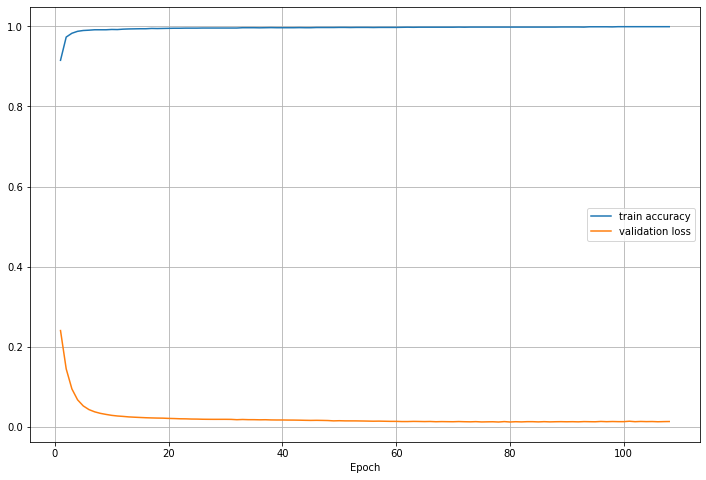

In [41]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, ms=5, label='train accuracy')
plt.plot(xs, y_vloss, ms=5, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()